In [1]:
%matplotlib inline
import sys
import json
import pandas
import random
from collections import defaultdict

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('/home/sungmin/Documents/projects_22/taper_graphs/smstyle-formal.mplstyle')

In [2]:
# helper functions
def evaluate(raw_result, only_crash=False):
    rows = []
    
    for bug_id, test_exec_results in raw_result.items():
        if bug_id in invalid_bugs:
            continue
        if only_crash and bug_id not in jcrashpack_bugs:
            continue
            
        for i, (fname, res) in enumerate(test_exec_results.items()):
            javalang_parse_error = False
            is_compile_error = False
            is_runtime_error = False
            buggy_version_failing = False
            fixed_version_failing = False
            success = False

            if isinstance(res, str):
                javalang_parse_error = True 
            elif res['buggy']['compile_error'] or res['fixed']['compile_error']:
                is_compile_error = True
            elif res['buggy']['runtime_error'] or res['fixed']['runtime_error']:
                is_runtime_error = True
            else:
                if res['buggy']['autogen_failed']:
                    buggy_version_failing = True
                if res['fixed']['autogen_failed']:
                    fixed_version_failing = True
                if buggy_version_failing and (not fixed_version_failing):
                    success = True
            
            rows.append({
                'project': bug_id.split('_')[0],
                'bug_id': bug_id,
                'test_no': i+1,
                'javalang_parse_error': javalang_parse_error,
                'is_compile_error': is_compile_error,
                'is_runtime_error': is_runtime_error,
                'buggy_version_failing': buggy_version_failing,
                'fixed_version_failing': fixed_version_failing,
                'fname': fname,
                'success': success,
            })
    
    return pandas.DataFrame(rows)

def get_file_results(fname, only_crash=False):
    with open(fname) as f:
        reproduction_df = evaluate(json.load(f), only_crash)
    
    reproduction_df['project'] = reproduction_df.bug_id.apply(lambda x: x.split('_')[0])
    
    return reproduction_df

def key_at_n(key, eval_df, count=50):
    succ_at_try = defaultdict(list)
    for idx in range(count):
        succ_at_try[idx] = set(eval_df[(eval_df.test_no == (idx+1)) & 
                                       (eval_df[key] > 0)]['bug_id'])

    x, ys = [], []
    org_list = list(range(count))
    x = org_list[:]
    for sim_idx in range(1000):
        random.shuffle(org_list)
        y = []
        succ_set = set()
        for idx in org_list:
            succ_set |= set(succ_at_try[idx])
            y.append(len(succ_set))
        ys.append(y)
    return np.array(ys)

with open('../data/etc/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

def get_results_at_n(results, n=10, cutoff=10):
    return np.median(key_at_n('success', results, count=n)[:, cutoff-1])

In [3]:
# results where we have memory usage data
label2results = {
    'codegen2-1B': get_results_at_n(get_file_results('../data/exec_results/codegen2-1B_2example_d4j.json')),
    'codegen2-3_7B': get_results_at_n(get_file_results('../data/exec_results/codegen2-3_7B_2example_d4j.json')),
    'codegen2-7B': get_results_at_n(get_file_results('../data/exec_results/codegen2-7B_2example_d4j.json')),
    'codegen2-16B': get_results_at_n(get_file_results('../data/exec_results/codegen2-16B_2example_d4j.json')),
    'Incoder-1B': get_results_at_n(get_file_results('../data/exec_results/Incoder-1B_2example_d4j.json')),
    'Incoder-6B': get_results_at_n(get_file_results('../data/exec_results/Incoder-6B_2example_d4j.json')),
    'starcoder': get_results_at_n(get_file_results('../data/exec_results/starcoder_n50_2example_d4j.json'), n=50),
}

In [4]:
memory_usage_df = pandas.read_csv('../data/etc/model_memory_usage.csv')
memory_usage_df['reproduced'] = memory_usage_df.apply(lambda x: label2results[x.analysis_name], axis=1)
memory_usage_df.head(10)

,full_model_name,analysis_name,parameters,base_setting,base_memory,inference_memory,quantize_gpu_setting,quantize_memory,quantize_inference_memory,notes,reproduced
0,Salesforce/codegen2-1B,codegen2-1B,1.0,single,4712,5768,single,1666,2906,NaN,0.0
1,Salesforce/codegen2-3_7B,codegen2-3_7B,3.7,single,14728,16218,single,3414,4802,NaN,0.0
2,Salesforce/codegen2-7B,codegen2-7B,7.0,multiple,29376,34274,single,5034,6940,NaN,70.0
3,Salesforce/codegen2-16B,codegen2-16B,16.0,multiple,64352,71322,single,10124,12656,NaN,76.0
4,facebook/Incoder-1B,Incoder-1B,1.0,single,5784,7050,single,1806,2632,NaN,28.0
5,facebook/Incoder-6B,Incoder-6B,6.0,multiple,29196,37772,single,4894,7256,NaN,44.0
6,bigcode/starcoder,starcoder,15.0,multiple,63384,86670,single,10028,17510,I can't get starcoder to use all 8191 of its c...,121.0


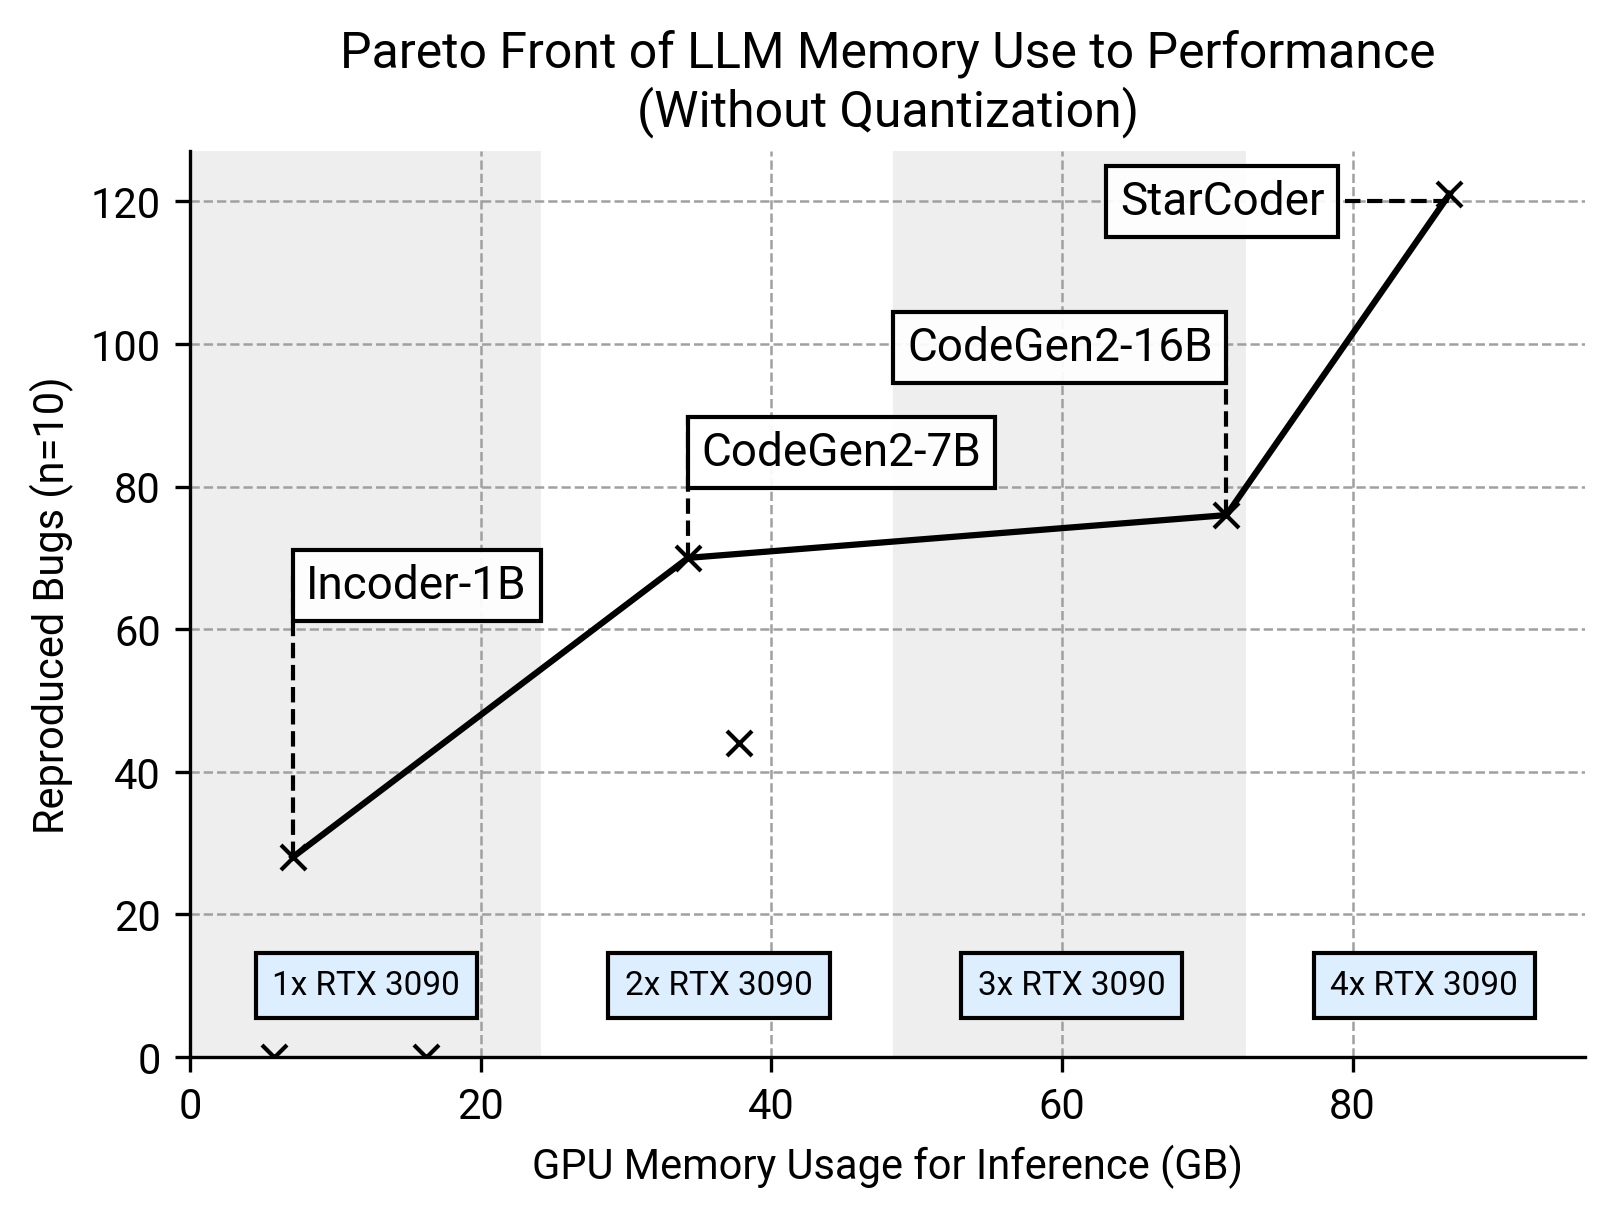

In [5]:
plt.plot(memory_usage_df.inference_memory/10**3, memory_usage_df.reproduced, 'x', color='black')
pareto_front_names = ['Incoder-1B', 'codegen2-7B', 'codegen2-16B', 'starcoder']
pareto_df = memory_usage_df[memory_usage_df.analysis_name.isin(pareto_front_names)].sort_values(by='reproduced')
plt.plot(pareto_df.inference_memory/10**3, pareto_df.reproduced, '-', color='black', label='Pareto Front')
plt.ylabel('Reproduced Bugs (n=10)')
plt.xlabel('GPU Memory Usage for Inference (GB)')
plt.title('Pareto Front of LLM Memory Use to Performance\n(Without Quantization)')

model_text_size=11
bbox = dict(facecolor='#ffffffee', edgecolor='black', boxstyle='square,pad=0.3')
plt.annotate('Incoder-1B', xy=(7050/1000, 28), xytext=(model_text_size*0.3, 60), textcoords="offset points",
             size=model_text_size, ha='left', va='bottom', bbox=bbox,)
plt.vlines(7050/1000, ymin=28, ymax=68, color='black', linewidth=1, linestyles='dashed')
plt.annotate('CodeGen2-7B', xy=(34274/1000, 70), xytext=(model_text_size*0.3, 20), textcoords="offset points",
             size=model_text_size, ha='left', va='bottom', bbox=bbox,)
plt.vlines(34274/1000, ymin=70, ymax=90, color='black', linewidth=1, linestyles='dashed')
plt.annotate('CodeGen2-16B', xy=(71322/1000, 76), xytext=(-model_text_size*0.3, 35), textcoords="offset points",
             size=model_text_size, ha='right', va='bottom', bbox=bbox,)
plt.vlines(71322/1000, ymin=76, ymax=101, color='black', linewidth=1, linestyles='dashed')
plt.annotate('StarCoder', xy=(86670/1000, 120), xytext=(-30, 0), textcoords="offset points",
             size=model_text_size, ha='right', va='center', bbox=bbox,)
plt.hlines(120, xmin=79.5, xmax=86670/1000, color='black', linewidth=1, linestyles='dashed')
plt.xlim(0, 96)
ylims = plt.gca().get_ylim()

for idx in range(4):
    gpu_block_size = 24268/1000
    background_color = '#eee' if idx % 2 == 0 else '#fff'
    plt.fill_between(x=[idx*gpu_block_size, (idx+1)*gpu_block_size], y1=ylims[0], y2=ylims[1], 
                     color=background_color)
    plt.text((idx+0.5)*gpu_block_size, 10, f'{idx+1}x RTX 3090', ha='center', va='center', fontsize=8,
             bbox=dict(facecolor='#ddeeff', edgecolor='black'))

plt.ylim(0, ylims[1])
plt.savefig('./figures/perf_gpu_pareto.pdf', bbox_inches='tight')
# plt.legend()